<a href="https://colab.research.google.com/github/EthanBrewerCity/NLP_CW_210008199/blob/main/NLP_CW_210008199.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NLP Project: Ethan Brewer <br>
Dataset: Dair-ai/emotion <br>
Project Type: Sentiment Analysis <br>


#Add Setup Features for Project <br>
This Includes device setup, installs, imports and loading the original dataset

In [45]:
# Installs necessary
!pip install transformers
!pip install datasets

In [46]:
# Add imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Further imports via pytorch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW as Adam # Import AdamW optimiser as previous instance was "deprecated"

# Imports from prior pip installs
from datasets import load_dataset
from transformers import DistilBertModel, DistilBertTokenizer, AdamW # AdamW on this version is stated as "Deprecated" so other version from torch.optim is used

# Sklearn imports
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load Dataset: dair-ai/emotion from Huggingface
dataset = load_dataset('emotion', trust_remote_code=True)

# Ensure the device being used is either the cuda or cpu (if cuda isn't available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preprocessing the Data
The Tokeniser and Model are taken and the data is preprocessed via BERT (Currently Distilled)

In [47]:
# Load Tokeniser and Model for dataset, In this case, BERT (Distilled vers. may change later)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

## Create the Neural Network and Define the Model Architecture

In [48]:
# Defining Model Architecture + Added dropout
class SentiClass(nn.Module):
  def __init__(self,model):
    super(SentiClass, self).__init__()
    self.model = model
    self.linear = nn.Linear(768,6)
  def forward(self,input_ids, attention_mask):
    outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
    last_hidden_state = outputs[0]
    logits = self.linear(last_hidden_state[:,0,:])
    return logits

# Creating intstance of the model
model = SentiClass(model)

## Define the Train, Eval and Eval for confusion matrix

In [49]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)

# Set the data format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Set up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=5e-5,weight_decay=0.01)
# Old Loss function, not usable as it is binary
#loss_fn = nn.BCEWithLogitsLoss()
#New loss function
loss_fn = nn.CrossEntropyLoss()

# Define the training loop and prepare data for loss graph
def train(model, train_loader, optimizer, loss_fn, device,num_epochs):
    model.train()
    train_losses=[]
    for epoch in range(num_epochs):
      epoch_loss= 0.0
      for batch in train_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = loss_fn(outputs, labels.long())
          print(loss)
          loss.backward()
          optimizer.step()

          epoch_loss+=loss.item()
      epoch_loss /= len(train_loader)
      train_losses.append(epoch_loss)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    return train_losses

# Define the evaluation loop
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs,dim=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return correct / total

def eval_conf_matrix(model, test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      print("Labels:", labels)

      outputs = model(input_ids, attention_mask)
      print("Outputs:", outputs)
      print("Outputs shape:", outputs.shape)
      predictions = torch.argmax(outputs, dim=1).cpu().numpy()

      all_preds.extend(predictions)
      all_labels.extend(labels.cpu().numpy())

  # Check expected range of class indices
  print("Min Label:", np.min(all_labels))
  print("Max Label:", np.max(all_labels))

  # Print true labels and predictions for inspection
  print("True Labels:", all_labels)
  print("Predictions:", all_preds)

  return all_labels, all_preds

##Training the model, adding padding and producing results for BERT

tensor(2.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6865, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4349, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5437, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5737, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5668, device='cuda:0', grad_fn=

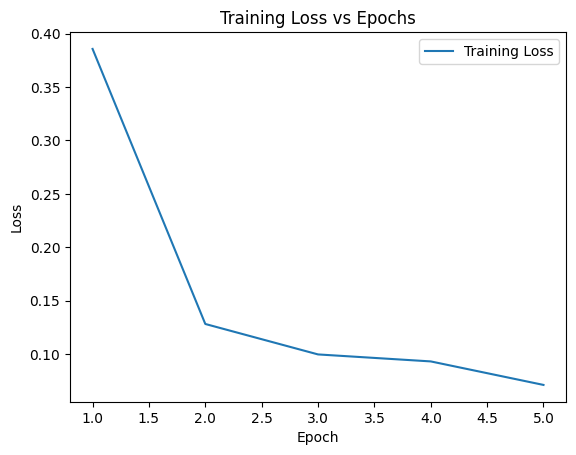

Labels: tensor([0, 0, 0, 1, 0, 4, 3, 1, 1, 3, 4, 0, 4, 1, 2, 0, 1, 0, 3, 1, 0, 1, 1, 0,
        0, 4, 3, 0, 4, 3, 4, 3], device='cuda:0')
Outputs: tensor([[ 7.8230e+00, -3.1302e-01, -7.7595e-01, -3.6572e+00, -2.3388e+00,
         -1.5837e+00],
        [ 7.9916e+00, -2.2565e-01, -1.5848e+00, -2.6898e+00, -1.8051e+00,
         -2.2722e+00],
        [ 8.1358e+00, -1.1238e+00, -1.2882e+00, -3.0325e+00, -1.9935e+00,
         -1.5330e+00],
        [-7.9600e-01,  7.8613e+00,  1.5812e-01, -2.2350e+00, -2.1778e+00,
         -3.3014e+00],
        [ 7.8774e+00, -3.5725e-01, -1.1411e+00, -3.5988e+00, -1.8496e+00,
         -1.9738e+00],
        [-8.9857e-01, -2.2407e+00, -1.3847e+00, -2.2077e+00,  7.8462e+00,
         -1.1023e+00],
        [-4.7968e-01,  2.2389e+00, -2.2828e+00,  3.1296e+00,  1.2133e+00,
         -3.7520e+00],
        [-1.3956e-01,  5.3989e+00,  3.1070e+00, -3.0417e+00, -2.4777e+00,
         -3.0867e+00],
        [-1.7965e+00,  7.6953e+00,  7.9904e-01, -2.7287e+00, -1.6653e+00,
   

<Figure size 640x480 with 0 Axes>

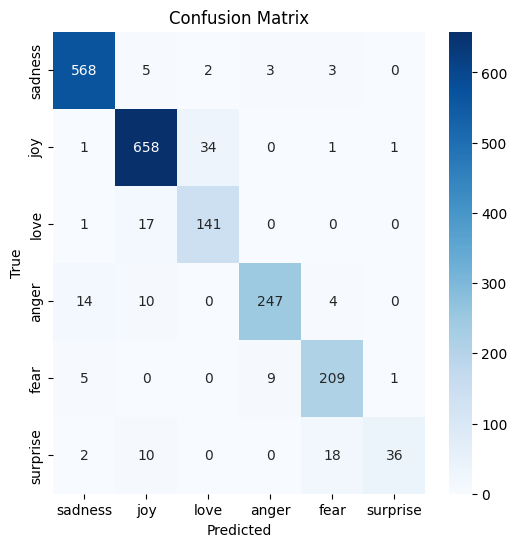

In [50]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Pad the sequences
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  labels = [item['label'] for item in batch]

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  attention_mask = pad_sequence(attention_mask,batch_first=True,padding_value=0)

  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'label': torch.tensor(labels)
  }

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)
# Set number of epochs
epoch_val = 5
history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.3f}')

# Loss graph for training
plt.figure(1)
plt.plot(range(1, epoch_val + 1), history , label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()


# Confusion matrix
plt.figure(2)
true_labels, predictions = eval_conf_matrix(model, test_loader, device)

# Compute confusion matrix - Not needed
#conf_mat = confusion_matrix(true_labels, predictions)

# Print confusion matrix - Debug test
#print("Confusion Matrix:", conf_mat)

conf_mat = confusion_matrix(true_labels,predictions)
plt.figure(figsize = (6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#for epoch in range(5):
#    history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
#    accuracy = evaluate(model, test_loader, device)
#    print(f'Epoch {epoch+1} - Test Accuracy: {accuracy:.3f}')